### データの読み込み

In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

from src.datprep_i import DatPreprocess
from src.datasets import ThingsMEGDataset_aug1
from src.models2 import BasicConvClassifier  # with glu
from src.utils import set_seed, set_lr, CosineScheduler

aug='_baseline'
transform_train=DatPreprocess(aug_sel=aug)
#transform_valid=DatPreprocess(aug_sel=aug)
#transform_test=DatPreprocess(aug_sel=aug)

# ------------------
#    Dataloader
# ------------------
loader_args = {"batch_size": 128, "num_workers": 4, "pin_memory": True}

train_set = ThingsMEGDataset_aug1("train", 'data', transform=transform_train)
val_set = ThingsMEGDataset_aug1("val", 'data', transform=transform_train)
test_set = ThingsMEGDataset_aug1("test", 'data', transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, **loader_args)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, **loader_args)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, **loader_args)


In [12]:
len(train_set) #50000 pictures, 32x32xRGB pixels

65728

In [27]:
Iter=iter(train_loader)
batch1=next(Iter)
print(batch1[0].shape, type(batch1[0]))

torch.Size([128, 271, 281]) <class 'torch.Tensor'>


### 自己教師あり学習の実装
- 初期の形式はMAEを利用することを想定していますが，他の自己教師あり学習を利用していただいて構いません．   

In [36]:
import math
import torch.nn as nn
import torch.optim as optim
from einops.layers.torch import Rearrange
from einops import rearrange

def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)

Attention

In [37]:
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn

In [38]:
attn = Attention(384, 12, 32, 0.) # dim, heads, dim_head, dropout
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
attn(x)[0].shape

torch.Size([4, 64, 384])

Feed-forward network
=multi layer perceptron

In [39]:
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(), # Gaussian Error Linear Unit: ReLUに似た形状だがx=0で微分可能
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)

In [40]:
ffn = FFN(384, 768, 0.) # (dim, hidden_dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
ffn(x).shape

torch.Size([4, 64, 384])

Transformer block

In [42]:
class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out

In [43]:
block = Block(384, 12, 32, 384, 0.) # (dim, heads, dim_head, mlp.dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
block(x).shape

torch.Size([4, 64, 384])

Patch embedding

In [44]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)


In [45]:
patch_emb = PatchEmbedding((48, 48), (4, 4), 3, 384) # (image_size, patch_size, in_channels, embed_dim)
x = torch.rand((4, 3, 48, 48))  # (Batch, Channel, Height, Width)
patch_emb(x).shape # (4 Batch, 8x8 patches, 384 embed_dim)

torch.Size([4, 144, 384])

Masked autoencoder

In [46]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    forward_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成
    np.random.shuffle(forward_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return forward_indexes, backward_indexes

In [47]:
x = np.random.randn((4))
forward_indexes, backward_indexes = random_indexes(x.shape[0])

print(f"original array: \n{x}")
print(f"forward indexes: \n{forward_indexes}\n{x[forward_indexes]}")  # ランダムに並べ替える
print(f"backward indexes: \n{backward_indexes}\n{x[forward_indexes][backward_indexes]}")  # 並べ替えた後にもとに戻す

original array: 
[ 0.49671415 -0.1382643   0.64768854  1.52302986]
forward indexes: 
[3 0 1 2]
[ 1.52302986  0.49671415 -0.1382643   0.64768854]
backward indexes: 
[1 2 3 0]
[ 0.49671415 -0.1382643   0.64768854  1.52302986]


In [48]:
def take_indexes(sequences, indexes):
    """
    パッチを並べ替えるための関数．

    Argument
    --------
    sequences : torch.Tensor
        入力画像をパッチ分割したデータ．(B, N, dim)の形状をしている．
    indexes : np.ndarray
        並べ替えるために利用するindex．
        random_indexesで生成したforward_indexesかbackward_indexesが入ることが想定されている．
    """
    # torch.gather: dim=1の時、indexで指定した位置の入力値を取ってきて並び替える
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(2).repeat(1, 1, sequences.shape[-1]))

In [49]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        # ratio: Encoderに入力しないパッチの割合
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        """
        B: バッチサイズ
        N: 系列長（＝パッチの数）
        dim: 次元数（＝埋め込みの次元数）
        """
        B, N, dim = patches.shape
        remain_N = int(N * (1 - self.ratio))  # Encoderに入力するパッチの数

        indexes = [random_indexes(N) for _ in range(B)]  # バッチごとに異なる順番のindexを作る
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # バッチを並べ替えるときのidx (B, N)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # 並べ替えたパッチをもとの順番に戻すためのidx  (B, N)

        patches = take_indexes(patches, forward_indexes)  # パッチを並べ替える
        patches = patches[:, :remain_N, :]  # Encoderに入力するパッチを抽出

        return patches, forward_indexes, backward_indexes

In [50]:
x = torch.rand((4, 4, 8))  # (Batch, N, dim) 見やすいように小さい行列にしている
patch_shuffle = PatchShuffle(ratio=0.75)
in_patches, forward_idx, backward_idx = patch_shuffle(x)

print(f"original data: shape {x.shape} \n {x}")
print(f"encoder input data: shape {in_patches.shape} \n {in_patches}")

original data: shape torch.Size([4, 4, 8]) 
 tensor([[[0.7307, 0.8974, 0.9086, 0.9824, 0.3881, 0.3824, 0.7014, 0.1173],
         [0.8242, 0.6828, 0.1276, 0.1555, 0.7673, 0.5919, 0.0600, 0.7400],
         [0.3207, 0.7133, 0.2181, 0.6741, 0.9880, 0.2020, 0.0210, 0.0627],
         [0.2871, 0.9178, 0.1938, 0.5795, 0.1562, 0.5057, 0.3545, 0.5565]],

        [[0.0242, 0.3236, 0.7900, 0.5075, 0.0012, 0.6673, 0.8176, 0.9012],
         [0.2510, 0.8931, 0.6011, 0.6216, 0.6711, 0.6598, 0.5351, 0.3228],
         [0.3217, 0.6782, 0.5457, 0.6947, 0.0358, 0.2729, 0.0879, 0.0034],
         [0.3165, 0.9275, 0.5716, 0.8911, 0.9193, 0.5187, 0.5908, 0.6876]],

        [[0.4511, 0.4456, 0.6065, 0.1029, 0.6729, 0.6881, 0.2431, 0.1972],
         [0.4645, 0.2460, 0.0071, 0.6164, 0.7725, 0.7812, 0.7649, 0.9304],
         [0.9150, 0.1825, 0.5682, 0.1165, 0.7036, 0.1783, 0.2197, 0.6197],
         [0.8379, 0.3729, 0.5718, 0.7115, 0.9666, 0.6682, 0.2655, 0.5117]],

        [[0.0185, 0.5544, 0.5716, 0.6958, 0.5212,

In [51]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192, num_layer=12,
                 heads=3, dim_head=64, mlp_dim=192, mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Encoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, emb_dim))  # class tokenの初期化
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches, emb_dim))  # positional embedding（学習可能にしている）
        self.shuffle = PatchShuffle(mask_ratio)

        # 入力画像をパッチに分割する
        self.patchify = PatchEmbedding(image_size, patch_size, 3, emb_dim)

        # Encoder（Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, img):
        # 1. 入力画像をパッチに分割して，positional embeddingする
        patches = self.patchify(img)
        patches = patches + self.pos_embedding

        # 2. 分割したパッチをランダムに並べ替えて，必要なパッチのみ得る
        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        # class tokenを結合
        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)

        # 3. Encoderで入力データを処理する
        features = self.layer_norm(self.transformer(patches))

        return features, backward_indexes

In [52]:
encoder = MAE_Encoder()

x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
features, backward_indexes = encoder(x)

print(features.shape)

torch.Size([4, 17, 192])


In [53]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192, num_layer=4,
                 heads=3, dim_head=64, mlp_dim=192, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Decoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.mask_token = torch.nn.Parameter(torch.rand(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.rand(1, num_patches+1, emb_dim))

        # Decoder(Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        # 埋め込みされた表現から画像を復元するためのhead
        self.head = torch.nn.Linear(emb_dim, 3 * patch_height * patch_width)
        # (B, N, dim)から(B, C, H, W)にreshapeするためのインスタンス
        self.patch2img = Rearrange("b (h w) (c p1 p2) -> b c (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.mask_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, features, backward_indexes):
        # 系列長
        T = features.shape[1]

        # class tokenがある分backward_indexesの最初に0を追加する
        # .toはデバイスの変更でよく利用するが，tensorを渡すことでdtypeを変えることができる
        backward_indexes = torch.cat([torch.zeros(backward_indexes.shape[0], 1).to(backward_indexes), backward_indexes+1], dim=1)

        # 1. mask_tokenを結合して並べ替える．
        # (B, N*(1-mask_ratio)+1, dim) -> (B, N+1, dim)
        features = torch.cat([features, self.mask_token.repeat(features.shape[0], backward_indexes.shape[1] - features.shape[1], 1)], dim=1)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = self.transformer(features)

        # class tokenを除去する
        # (B, N+1, dim) -> (B, N, dim)
        features = features[:, 1:, :]

        # 2. 画像を再構成する．
        # (B, N, dim) -> (B, N, 3 * patch_height * patch_width)
        patches = self.head(features)

        # MAEではマスクした部分でのみ損失関数を計算するため，maskも一緒に返す
        mask = torch.zeros_like(patches)
        mask[:, T-1:] = 1  # cls tokenを含めていた分ずらしている
        mask = take_indexes(mask, backward_indexes[:, 1:] - 1)

        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

In [54]:
decoder = MAE_Decoder()
img, mask = decoder(features, backward_indexes)

print(img.shape)
print(mask.shape)

torch.Size([4, 3, 48, 48])
torch.Size([4, 3, 48, 48])


In [55]:
class MAE_ViT(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192,
                 enc_layers=12, enc_heads=3, enc_dim_head=64, enc_mlp_dim=768,
                 dec_layers=4, dec_heads=3, dec_dim_head=64, dec_mlp_dim=768,
                 mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------
        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        {enc/dec}_layers : int
            Encoder / Decoderに含まれるBlockの数．
        {enc/dec}_heads : int
            Encoder / DecoderのMulti-Head Attentionのヘッドの数．
        {enc/dec}_dim_head : int
            Encoder / DecoderのMulti-Head Attentionの各ヘッドの次元数．
        {enc/dec}_mlp_dim : int
            Encoder / DecoderのFeed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, enc_layers,
                                   enc_heads, enc_dim_head, enc_mlp_dim, mask_ratio, dropout)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, dec_layers,
                                   dec_heads, dec_dim_head, dec_mlp_dim, dropout)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        rec_img, mask = self.decoder(features, backward_indexes)
        return rec_img, mask

    def get_last_selfattention(self, x):
        patches = self.encoder.patchify(x)
        patches = patches + self.encoder.pos_embedding

        patches = torch.cat([self.encoder.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.encoder.transformer):
            if i < len(self.encoder.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [56]:
mae = MAE_ViT()
x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
rec_img, mask = mae(x)

print(rec_img.shape)
print(mask.shape)

torch.Size([4, 3, 48, 48])
torch.Size([4, 3, 48, 48])


学習率スケジューラ

In [57]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

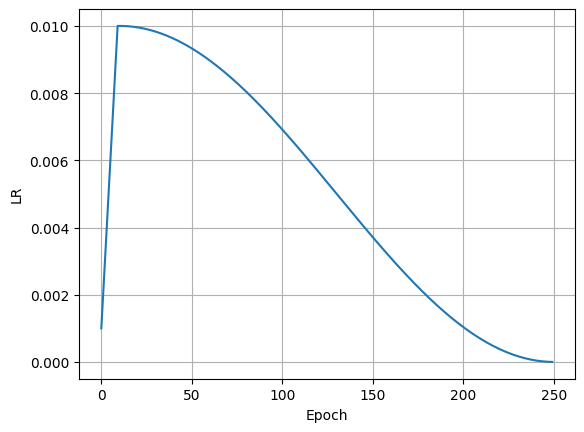

In [58]:
import matplotlib.pyplot as plt

scheduler = CosineScheduler(epochs=250, warmup_length=10, lr=0.01)
x = np.arange(250)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

学習率変更関数

In [59]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [60]:
# ハイパーパラメータの設定
config = {
    "image_size": [271, 281],
    "patch_size": [6, 6],
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [61]:
# モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MAE_ViT(**config).to(device)
epochs = 20
lr = 0.024
warmup_length=int(epochs*0.05)
#batch_size = 512
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
scheduler = CosineScheduler(epochs, lr, warmup_length)
step_count = 0

AssertionError: パッチサイズは，入力画像のサイズを割り切れる必要があります．

### 事前学習（自己教師あり学習）

In [114]:
model_path="./model/pretrain_01.pth"
model_w_path="./model/pretrain_w_01.pth"

In [115]:
run_1st=False
if run_1st==True:
    for epoch in range(epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _, _ in tqdm(dataloader_train, desc="Train"):
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()  #added

        # モデルの評価
        with torch.no_grad():
            for x, _, _ in tqdm(dataloader_valid, desc="Valid"):
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(dataloader_train):.4f} Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)

restart

In [116]:
run_2nd=False
if run_2nd==True:
    model = MAE_ViT(**config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    t_loss = checkpoint['train_loss']
    v_loss = checkpoint['valid_loss']

    for epoch in range(epoch, epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _ in dataloader_train:
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()

        # モデルの評価
        with torch.no_grad():
            for x, _ in dataloader_valid:
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(dataloader_train):.4f} Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)


保存したモデルで推論

In [117]:
model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()
x, _, _ = next(iter(dataloader_valid))
with torch.no_grad():
    rec_img, mask = model(x.to(device))

x, rec_img, mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

推論結果の描画

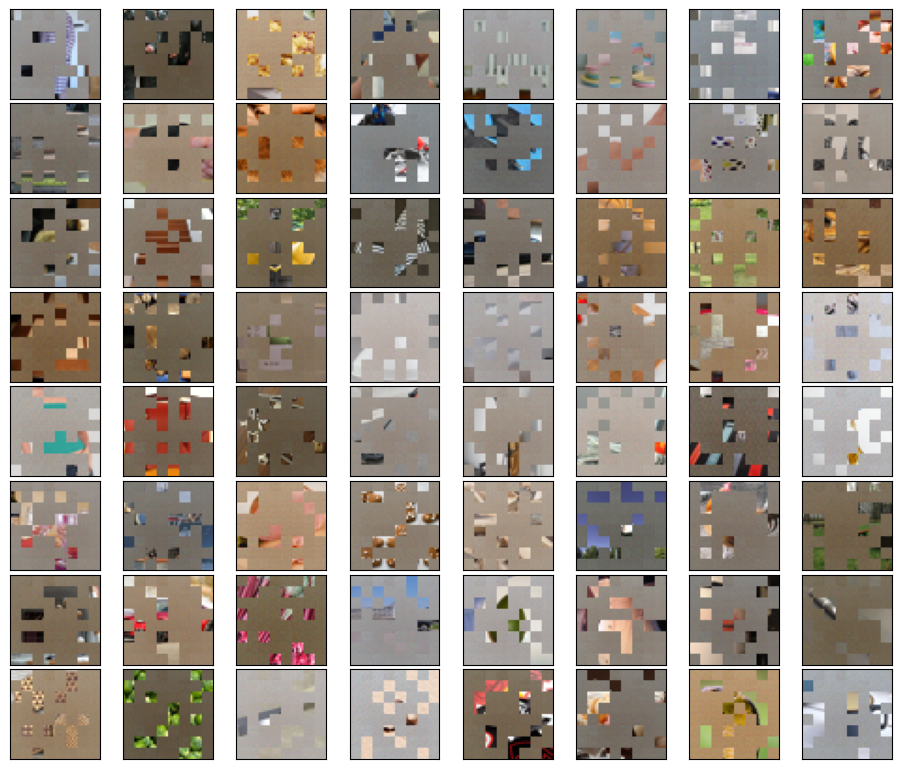

In [118]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
# imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
i = 0
for img in imgs[:64]:
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

元画像の描画

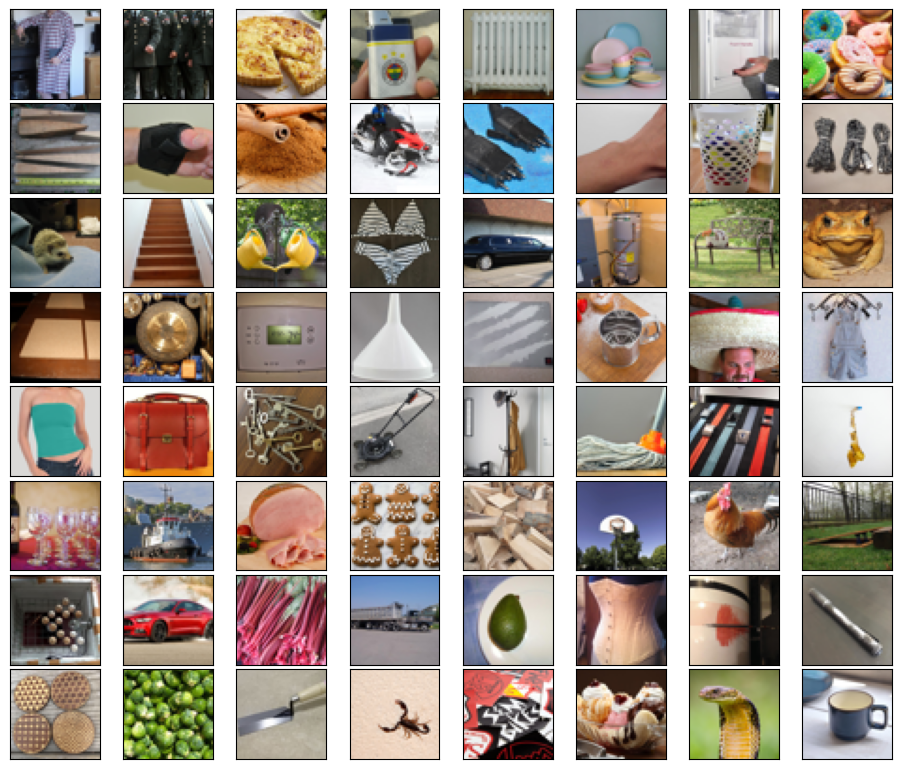

In [119]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
imgs = (x.data + 1) / 2
for img in imgs[:64]:
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

Attention mapの可視化

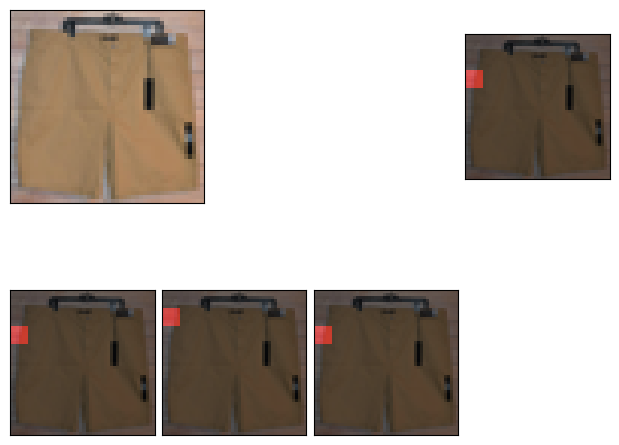

In [120]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((48, 48, 2))), axis=2)
        ax = fig.add_subplot(2, 4, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)


model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
x, _, _ = next(iter(dataloader_valid))  # 検証用データからデータを取得する

display_attn_map(model, x)

### Linear probing

In [121]:
val_size = 3000
train_data, valid_data = torch.utils.data.random_split(image_dataset, [len(image_dataset) - val_size, val_size])

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

#trainval_data.transform=valid_transform
image_dataset.transform=valid_transform

batch_size = 256

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)


クラス分類器

In [122]:
class Classifier(nn.Module):
    def __init__(self, encoder: MAE_Encoder, num_classes=1854):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = patches + self.pos_embedding  # positional embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        features = self.layer_norm(self.transformer(patches))
        logits = self.head(features[:, 0])  # cls tokenのみを入力する
        return logits

    def get_last_selfattention(self, x):
        patches = self.patchify(x)
        patches = patches + self.pos_embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.transformer):
            if i < len(self.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [123]:
# ハイパーパラメータの設定
config = {
    "image_size": [48, 48],
    "patch_size": [6, 6],
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [124]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model = MAE_ViT(**config).to(device)
pretrained_model.load_state_dict(torch.load(model_path, map_location=device))


encoder = pretrained_model.encoder

# モデルの定義
model = Classifier(encoder).to(device)

epochs = 20
lr = 0.005
warmup_length = int(epochs*0.05)
#batch_size = 128
optimizer = optim.AdamW(model.head.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)  # 分類器部分のみ学習
scheduler = CosineScheduler(epochs, lr, warmup_length)
criterion = nn.CrossEntropyLoss()

分類器の学習

In [125]:
class_path="./model/classifier_01.pth"

In [126]:
for epoch in range(epochs):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.
    scaler = torch.cuda.amp.GradScaler()  # added
    for x, t, _ in tqdm(dataloader_train, desc="Train"):
        x, t = x.to(device), t.to(device)
        with torch.cuda.amp.autocast():  # added

            
            pred = model(x)
            train_loss = criterion(pred, t)

        train_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

        optimizer.zero_grad()
        #train_loss.backward()
        scaler.scale(train_loss).backward()

        #optimizer.step()
        scaler.step(optimizer)

        total_train_loss += train_loss.item()
        total_train_acc += train_acc

        scaler.update()

    with torch.no_grad():
        for x, t, _ in dataloader_valid:
            x, t = x.to(device), t.to(device)
            pred = model(x)

            valid_loss = criterion(pred, t)
            valid_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc

    print(f"Epoch[{epoch+1} / {epochs}]",
          f"Train Loss: {total_train_loss/len(dataloader_train):.4f}",
          f"Train Acc.: {total_train_acc/len(dataloader_train):.4f}",
          f"Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}",
          f"Valid Acc.: {total_valid_acc/len(dataloader_valid):.4f}")

torch.save(model.state_dict(), class_path)

Train: 100%|██████████| 53/53 [02:50<00:00,  3.22s/it]


Epoch[1 / 20] Train Loss: 7.9130 Train Acc.: 0.0010 Valid Loss: 7.7592 Valid Acc.: 0.0008


Train: 100%|██████████| 53/53 [02:36<00:00,  2.95s/it]


Epoch[2 / 20] Train Loss: 7.6707 Train Acc.: 0.0014 Valid Loss: 7.7481 Valid Acc.: 0.0027


Train: 100%|██████████| 53/53 [02:40<00:00,  3.03s/it]


Epoch[3 / 20] Train Loss: 7.6397 Train Acc.: 0.0019 Valid Loss: 7.7371 Valid Acc.: 0.0003


Train: 100%|██████████| 53/53 [02:37<00:00,  2.97s/it]


Epoch[4 / 20] Train Loss: 7.6185 Train Acc.: 0.0017 Valid Loss: 7.7149 Valid Acc.: 0.0019


Train: 100%|██████████| 53/53 [19:46<00:00, 22.38s/it]   


Epoch[5 / 20] Train Loss: 7.5912 Train Acc.: 0.0023 Valid Loss: 7.7189 Valid Acc.: 0.0027


Train: 100%|██████████| 53/53 [02:38<00:00,  2.98s/it]


Epoch[6 / 20] Train Loss: 7.5761 Train Acc.: 0.0026 Valid Loss: 7.7043 Valid Acc.: 0.0040


Train: 100%|██████████| 53/53 [02:41<00:00,  3.06s/it]


Epoch[7 / 20] Train Loss: 7.5481 Train Acc.: 0.0028 Valid Loss: 7.6886 Valid Acc.: 0.0036


Train: 100%|██████████| 53/53 [02:38<00:00,  3.00s/it]


Epoch[8 / 20] Train Loss: 7.5226 Train Acc.: 0.0030 Valid Loss: 7.6833 Valid Acc.: 0.0013


Train: 100%|██████████| 53/53 [02:42<00:00,  3.06s/it]


Epoch[9 / 20] Train Loss: 7.4974 Train Acc.: 0.0031 Valid Loss: 7.6550 Valid Acc.: 0.0044


Train: 100%|██████████| 53/53 [02:39<00:00,  3.02s/it]


Epoch[10 / 20] Train Loss: 7.4773 Train Acc.: 0.0043 Valid Loss: 7.6385 Valid Acc.: 0.0037


Train: 100%|██████████| 53/53 [02:40<00:00,  3.03s/it]


Epoch[11 / 20] Train Loss: 7.4471 Train Acc.: 0.0035 Valid Loss: 7.6375 Valid Acc.: 0.0044


Train: 100%|██████████| 53/53 [02:40<00:00,  3.03s/it]


Epoch[12 / 20] Train Loss: 7.4207 Train Acc.: 0.0043 Valid Loss: 7.6216 Valid Acc.: 0.0027


Train: 100%|██████████| 53/53 [04:46<00:00,  5.41s/it]


Epoch[13 / 20] Train Loss: 7.3922 Train Acc.: 0.0051 Valid Loss: 7.6056 Valid Acc.: 0.0049


Train: 100%|██████████| 53/53 [03:18<00:00,  3.75s/it]


Epoch[14 / 20] Train Loss: 7.3658 Train Acc.: 0.0060 Valid Loss: 7.5976 Valid Acc.: 0.0033


Train: 100%|██████████| 53/53 [02:41<00:00,  3.05s/it]


Epoch[15 / 20] Train Loss: 7.3425 Train Acc.: 0.0067 Valid Loss: 7.5969 Valid Acc.: 0.0027


Train: 100%|██████████| 53/53 [02:40<00:00,  3.03s/it]


Epoch[16 / 20] Train Loss: 7.3206 Train Acc.: 0.0061 Valid Loss: 7.5945 Valid Acc.: 0.0040


Train: 100%|██████████| 53/53 [02:39<00:00,  3.01s/it]


Epoch[17 / 20] Train Loss: 7.3025 Train Acc.: 0.0094 Valid Loss: 7.5938 Valid Acc.: 0.0055


Train: 100%|██████████| 53/53 [02:38<00:00,  3.00s/it]


Epoch[18 / 20] Train Loss: 7.2859 Train Acc.: 0.0100 Valid Loss: 7.5906 Valid Acc.: 0.0047


Train: 100%|██████████| 53/53 [02:38<00:00,  2.99s/it]


Epoch[19 / 20] Train Loss: 7.2763 Train Acc.: 0.0109 Valid Loss: 7.5914 Valid Acc.: 0.0044


Train: 100%|██████████| 53/53 [02:39<00:00,  3.01s/it]


Epoch[20 / 20] Train Loss: 7.2701 Train Acc.: 0.0127 Valid Loss: 7.5932 Valid Acc.: 0.0044
